Total Fixations: 588
Total Saccades: 26


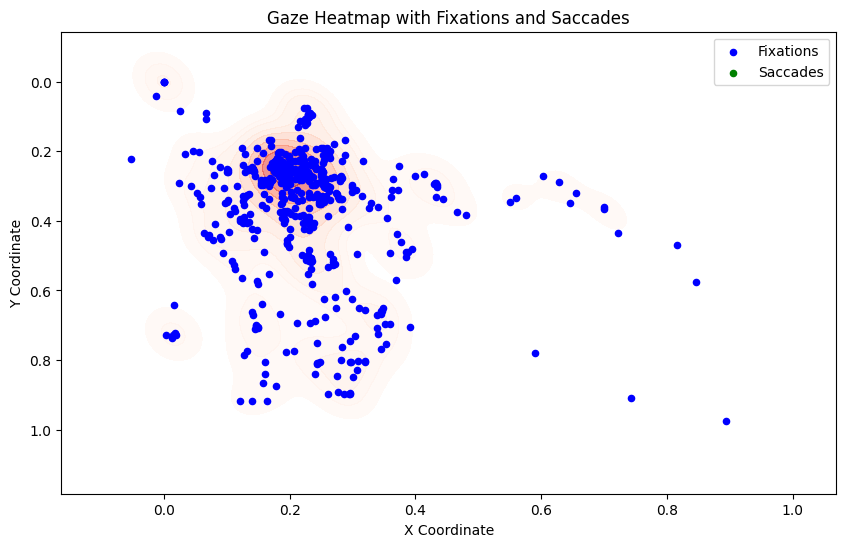

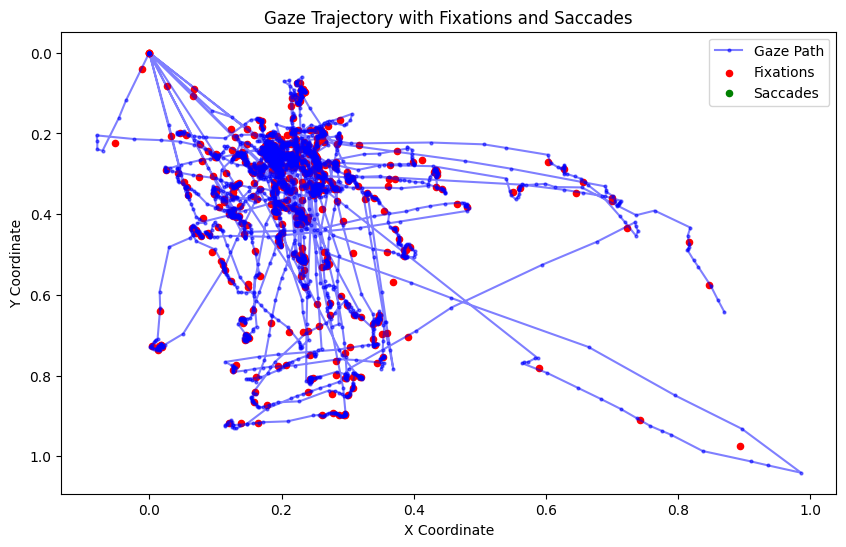

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def identify_fixations_ivt_idt(df, dispersion_threshold=8, duration_threshold=50, velocity_threshold=10, time_interval=100):
    gaze_data = df[['TIMETICK(f=10000000)', 'FPOGX', 'FPOGY', 'HRV', 'GSR', 'LPD', 'RPD']].copy()
    gaze_data = gaze_data.dropna()
    gaze_data['TIMETICK'] = gaze_data['TIMETICK(f=10000000)'] / 10000.0
    gaze_data = gaze_data.sort_values(by='TIMETICK')

    fixations, saccades = [], []
    velocities = []
    prev_x, prev_y, prev_time = None, None, None

    for index, row in gaze_data.iterrows():
        if prev_x is not None:
            distance = np.sqrt((row['FPOGX'] - prev_x) ** 2 + (row['FPOGY'] - prev_y) ** 2)
            time_diff = row['TIMETICK'] - prev_time
            velocity = (distance / (time_diff / 1000)) if time_diff > 0 else 0
            velocities.append(velocity)
        else:
            velocities.append(0)
        prev_x, prev_y, prev_time = row['FPOGX'], row['FPOGY'], row['TIMETICK']
    
    gaze_data['Velocity'] = velocities
    current_time = gaze_data['TIMETICK'].min()
    end_time = gaze_data['TIMETICK'].max()
    
    while current_time <= end_time:
        subset = gaze_data[(gaze_data['TIMETICK'] >= current_time) & (gaze_data['TIMETICK'] < current_time + time_interval)]
        if not subset.empty:
            dispersion = (subset[['FPOGX', 'FPOGY']].max() - subset[['FPOGX', 'FPOGY']].min()).sum()
            duration = subset['TIMETICK'].max() - subset['TIMETICK'].min()
            max_velocity = subset['Velocity'].max()

            if dispersion <= dispersion_threshold and duration >= duration_threshold:
                fixations.append({'Start_Time': subset['TIMETICK'].min(), 'End_Time': subset['TIMETICK'].max(),
                                  'Mean_X': subset['FPOGX'].mean(), 'Mean_Y': subset['FPOGY'].mean(),
                                  'Fixation': 1, 'Saccade': 0})
            if max_velocity >= velocity_threshold or dispersion > dispersion_threshold:
                saccades.append({'Start_Time': subset['TIMETICK'].min(), 'End_Time': subset['TIMETICK'].max(),
                                 'Amplitude': dispersion, 'Velocity': max_velocity,
                                 'Fixation': 0, 'Saccade': 1})
        current_time += time_interval
    
    fixations_df = pd.DataFrame(fixations)
    saccades_df = pd.DataFrame(saccades)
    all_data = pd.concat([fixations_df, saccades_df], ignore_index=True).sort_values(by='Start_Time')
    
    return all_data, gaze_data

file_path = "C:/Users/ABHINAV RANA/Downloads/alt_4_all_gaze.csv/div_5_all_gaze.csv"
df = pd.read_csv(file_path)
preprocessed_data, labeled_data = identify_fixations_ivt_idt(df)

preprocessed_output_file = "C:/Users/ABHINAV RANA/preprocessed_gaze_data.csv"
preprocessed_data.to_csv(preprocessed_output_file, index=False)
print("Total Fixations:", preprocessed_data['Fixation'].sum())
print("Total Saccades:", preprocessed_data['Saccade'].sum())

# Plot gaze heatmap
plt.figure(figsize=(10, 6))
sns.kdeplot(x=labeled_data['FPOGX'], y=labeled_data['FPOGY'], cmap='Reds', fill=True, alpha=0.5)
plt.scatter(preprocessed_data[preprocessed_data['Fixation'] == 1]['Mean_X'], 
            preprocessed_data[preprocessed_data['Fixation'] == 1]['Mean_Y'], 
            color='blue', s=20, label='Fixations')
plt.scatter(preprocessed_data[preprocessed_data['Saccade'] == 1]['Mean_X'], 
            preprocessed_data[preprocessed_data['Saccade'] == 1]['Mean_Y'], 
            color='green', s=20, label='Saccades')
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Gaze Heatmap with Fixations and Saccades")
plt.legend()
plt.gca().invert_yaxis()
plt.show()

# Plot gaze trajectory
plt.figure(figsize=(10, 6))
plt.plot(labeled_data['FPOGX'], labeled_data['FPOGY'], linestyle='-', marker='o', markersize=2, color='blue', alpha=0.5, label='Gaze Path')
plt.scatter(preprocessed_data[preprocessed_data['Fixation'] == 1]['Mean_X'], 
            preprocessed_data[preprocessed_data['Fixation'] == 1]['Mean_Y'], 
            color='red', s=20, label='Fixations')
plt.scatter(preprocessed_data[preprocessed_data['Saccade'] == 1]['Mean_X'], 
            preprocessed_data[preprocessed_data['Saccade'] == 1]['Mean_Y'], 
            color='green', s=20, label='Saccades')
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Gaze Trajectory with Fixations and Saccades")
plt.legend()
plt.gca().invert_yaxis()
plt.show()
